# Description

This notebook intends to gather all the functionalities you'll have to implement for assignment 2.3.

# Load libraries

In [1]:
import numpy as np
import igl
import meshplot as mp
import time

import sys as _sys
_sys.path.append("../src_solution")
from elasticsolid import *
from elasticenergy import *
from matplotlib import gridspec
import matplotlib.pyplot as plt

shadingOptions = {
    "flat":True,
    "wireframe":False,   
}

rot = np.array(
    [[1, 0, 0 ],
     [0, 0, 1],
     [0, -1, 0 ]]
)

# Load mesh

Several meshes are available for you to play with under `data/`: `ball.obj`, `dinosaur.obj`, and `beam.obj`. You can also uncomment the few commented lines below to manipulate a simple mesh made out of 2 tetrahedra.

In [2]:
v, _, _, t, _, _ = igl.read_obj("../data/dinosaur.obj")
# v, _, _, t, _, _ = igl.read_obj("../data/beam.obj")

# t = np.array([
#         [0, 1, 2, 3],
#         [1, 2, 3, 4]
#     ])
# v = np.array([
#     [0., 0., 0.],
#     [1., 0., 0.],
#     [0., 1., 0.],
#     [0., 0., 1.],
#     [2/3, 2/3, 2/3]
# ])

be = igl.edges(igl.boundary_facets(t))
e = igl.edges(t)

aabb = np.max(v, axis=0) - np.min(v, axis=0)
length_scale = np.mean(aabb)

p = mp.plot(v @ rot.T, t, shading=shadingOptions)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.987469…

# Linear/Non-Linear Elastic Solid

## Instantiation

We first specify the elasticity model to use for the elastic solid, as well as pinned vertices, and volumetric forces.

In [3]:
rho     = 131  # [kg.m-3]
young   = 3e8 # [Pa] 
poisson = 0.2
force_mass = np.zeros(shape = (3,))
force_mass[2] = - rho * 9.81

# minX    = np.min(v[:, 0])
# pin_idx = np.arange(v.shape[0])[v[:, 0] < minX + 0.2*aabb[0]]
minZ    = np.min(v[:, 2])
pin_idx = np.arange(v.shape[0])[v[:, 2] < minZ + 0.1*aabb[2]]

# ee    = LinearElasticEnergy(young, poisson)
ee    = NeoHookeanElasticEnergy(young, poisson)
solid = ElasticSolid(v, t, ee, rho=rho, pin_idx=pin_idx, f_mass=force_mass)


## Deform the mesh

This should now involve elastic forces computation.

In [4]:
v_def = v.copy()
v_def[:, 0] *= 2.
solid.update_def_shape(v_def)

p = mp.plot(solid.v_def @ rot.T, solid.t, shading=shadingOptions)
p.add_points(solid.v_def[solid.pin_idx, :] @ rot.T, shading={"point_color":"black", "point_size": 0.1 * length_scale})
forcesScale = 2 * np.max(np.linalg.norm(solid.f_ext, axis=1))
p.add_lines(solid.v_def @ rot.T, (solid.v_def + solid.f_ext / forcesScale) @ rot.T)
p.add_edges(v @ rot.T, be, shading={"line_color": "blue"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-3.974938…

3

## Find equilibrium

We compare different methods: number of steps, computation time.

In [5]:
n_steps = 1000
thresh  = 1.
v_init = v.copy()

## Gradient descent

In [6]:
%run ../src_solution/Utils.py

report_GD = equilibrium_convergence_report_GD(solid, v_init, n_steps, 1e-8, thresh=thresh)
energies_el_GD  = report_GD['energies_el']
energies_ext_GD = report_GD['energies_ext']
energy_GD       = energies_el_GD + energies_ext_GD
residuals_GD    = report_GD['residuals']
times_GD        = report_GD['times']
idx_stop_GD     = report_GD['idx_stop']
v_def_GD        = solid.v_def.copy()

# Lastly, plot the resulting shape
p = mp.plot(v_def_GD @ rot.T, solid.t, shading=shadingOptions)
forcesScale = 2 * np.max(np.linalg.norm(solid.f_ext, axis=1))
p.add_lines(v_def_GD @ rot.T, (solid.v_def + solid.f_ext / forcesScale) @ rot.T)
p.add_points(v_def_GD[pin_idx, :] @ rot.T, shading={"point_color":"black", "point_size": 0.1 * length_scale})
p.add_edges(v @ rot.T, be, shading={"line_color": "blue"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-1.987832…

3

## BFGS

In [7]:
report_BFGS = equilibrium_convergence_report_BFGS(solid, v_init, n_steps, 1e-8, thresh=thresh)
energies_el_BFGS  = report_BFGS['energies_el']
energies_ext_BFGS = report_BFGS['energies_ext']
energy_BFGS       = energies_el_BFGS + energies_ext_BFGS
residuals_BFGS    = report_BFGS['residuals']
times_BFGS        = report_BFGS['times']
idx_stop_BFGS     = report_BFGS['idx_stop']
v_def_BFGS        = solid.v_def.copy()

# Lastly, plot the resulting shape
p = mp.plot(v_def_BFGS @ rot.T, solid.t, shading=shadingOptions)
forcesScale = 2 * np.max(np.linalg.norm(solid.f_ext, axis=1))
p.add_lines(v_def_BFGS @ rot.T, (solid.v_def + solid.f_ext / forcesScale) @ rot.T)
p.add_points(v_def_BFGS[pin_idx, :] @ rot.T, shading={"point_color":"black", "point_size": 0.1 * length_scale})
p.add_edges(v @ rot.T, be, shading={"line_color": "blue"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.272792…

3

## Newton-CG

In [8]:
report_NCG = equilibrium_convergence_report_NCG(solid, v_init, n_steps, thresh=thresh)
energies_el_NCG  = report_NCG['energies_el']
energies_ext_NCG = report_NCG['energies_ext']
energy_NCG       = energies_el_NCG + energies_ext_NCG
residuals_NCG    = report_NCG['residuals']
times_NCG        = report_NCG['times']
idx_stop_NCG     = report_NCG['idx_stop']
v_def_NCG        = solid.v_def.copy()

# Lastly, plot the resulting shape
p = mp.plot(v_def_NCG @ rot.T, solid.t, shading=shadingOptions)
forcesScale = 2 * np.max(np.linalg.norm(solid.f_ext, axis=1))
p.add_lines(v_def_NCG @ rot.T, (solid.v_def + solid.f_ext / forcesScale) @ rot.T)
p.add_points(v_def_NCG[pin_idx, :] @ rot.T, shading={"point_color":"black", "point_size": 0.1 * length_scale})
p.add_edges(v @ rot.T, be, shading={"line_color": "blue"})

Energy: -190983.34419001488 Force residual norm: 10618131.41171316 Line search Iters: 1
Energy: -513282.085404012 Force residual norm: 4923901.002545721 Line search Iters: 0
Energy: -577902.951876238 Force residual norm: 2353113.9754313435 Line search Iters: 0
Energy: -703911.4246812621 Force residual norm: 1090470.4163375013 Line search Iters: 0
Energy: -823724.2323294486 Force residual norm: 1506872.6262888336 Line search Iters: 0
Energy: -830564.4084159082 Force residual norm: 673428.693893899 Line search Iters: 0
Energy: -1022629.6566556676 Force residual norm: 5371701.717481048 Line search Iters: 3
Energy: -1099174.2749568364 Force residual norm: 2502298.5315386555 Line search Iters: 0
Energy: -1115564.9037965848 Force residual norm: 1118992.3747167499 Line search Iters: 0
Energy: -1131991.237104091 Force residual norm: 541495.0111026717 Line search Iters: 0
Energy: -1226399.3979004594 Force residual norm: 6995501.414325742 Line search Iters: 2
Energy: -1356613.460114614 Force res

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0873091…

3

## Compare the different algorithms

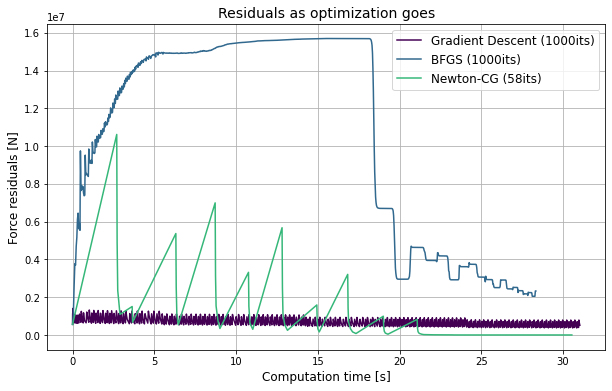

In [9]:
cmap   = plt.get_cmap('viridis')
colors = cmap(np.linspace(0., 1., 4))

gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
fig = plt.figure(figsize=(10, 6))

axTmp = plt.subplot(gs[0, 0])
axTmp.plot(times_GD[:idx_stop_GD+1], residuals_GD[:idx_stop_GD+1], c=colors[0], 
           label="Gradient Descent ({:}its)".format(idx_stop_GD))
axTmp.plot(times_BFGS[:idx_stop_BFGS+1], residuals_BFGS[:idx_stop_BFGS+1], c=colors[1], 
           label="BFGS ({:}its)".format(idx_stop_BFGS))
axTmp.plot(times_NCG[:idx_stop_NCG+1], residuals_NCG[:idx_stop_NCG+1], c=colors[2], 
           label="Newton-CG ({:}its)".format(idx_stop_NCG))
y_lim = axTmp.get_ylim()
axTmp.set_title("Residuals as optimization goes", fontsize=14)
axTmp.set_xlabel("Computation time [s]", fontsize=12)
axTmp.set_ylabel("Force residuals [N]", fontsize=12)
axTmp.set_ylim(y_lim)
plt.legend(fontsize=12)
plt.grid()
plt.show()

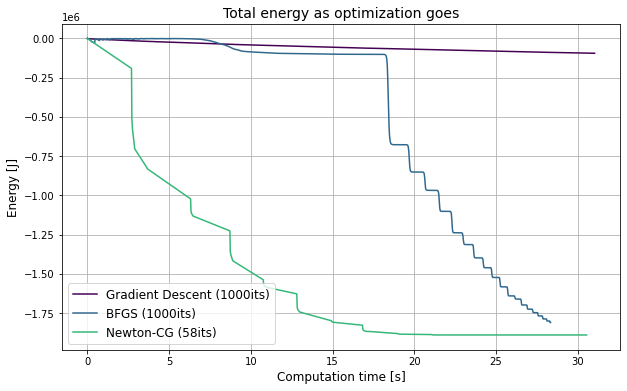

In [10]:
gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
fig = plt.figure(figsize=(10, 6))

axTmp = plt.subplot(gs[0, 0])
axTmp.plot(times_GD[:idx_stop_GD+1], energy_GD[:idx_stop_GD+1], c=colors[0], 
           label="Gradient Descent ({:}its)".format(idx_stop_GD))
axTmp.plot(times_BFGS[:idx_stop_BFGS+1], energy_BFGS[:idx_stop_BFGS+1], c=colors[1], 
           label="BFGS ({:}its)".format(idx_stop_BFGS))
axTmp.plot(times_NCG[:idx_stop_NCG+1], energy_NCG[:idx_stop_NCG+1], c=colors[2], 
           label="Newton-CG ({:}its)".format(idx_stop_NCG))
y_lim = axTmp.get_ylim()
axTmp.set_title("Total energy as optimization goes", fontsize=14)
axTmp.set_xlabel("Computation time [s]", fontsize=12)
axTmp.set_ylabel("Energy [J]", fontsize=12)
axTmp.set_ylim(y_lim)
plt.legend(fontsize=12)
plt.grid()
plt.show()